In [1]:
cd "/content/drive/MyDrive/Siamese Network"

/content/drive/MyDrive/Siamese Network


In [2]:
pwd

'/content/drive/MyDrive/Siamese Network'

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50  # Pretrained network
import torchvision.transforms as T
from model import SiameseNetwork
from loss import ContrastiveLoss
from data import SiameseDataset, Grayscale
from utils import train_fn
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("ggplot")
% matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")
# training, network configuration
transform = T.Compose([
    T.Resize(257),
    T.CenterCrop(256),
    T.ToTensor(),
    Grayscale()
])

Running on device: cuda


In [5]:
# Directory structure
# root
# | -> Samples-1
# | -> Samples-2
root = Path("")  # point towards the path of the dataset
print(root.absolute())

/content/drive/MyDrive/Siamese Network


In [6]:
emb_dim = 2048
bs = 16
n_epochs = 50
lr = 1e-3
alpha = 0.25
freeze = True

In [7]:
siamese_ds = SiameseDataset(root / "sketches", root / "photos", transform=transform)
siamese_dl = DataLoader(siamese_ds, bs, shuffle=True)

encoder_network = resnet50(True)
network = SiameseNetwork(encoder_network=encoder_network, emb_dim=emb_dim, rate=0.6, freeze=freeze).to(device)
optimizer = optim.Adam(network.parameters(), lr=lr)
loss_fn = ContrastiveLoss(alpha=alpha, device=device)

print(f"Found a total of {len(siamese_ds)} samples")

n_params = 0
for param in network.parameters():
    n_params += param.numel()

print(f"{n_params} parameters")

Found a total of 88 samples
40291392 parameters


In [ ]:
# Uncomment to run the network
losses = []
for _ in range(n_epochs):
    loss = train_fn(network, loss_fn, optimizer, siamese_dl, device)
    losses.append(loss)

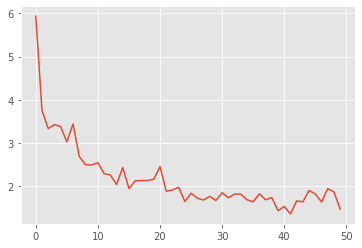

In [9]:
# Loss Vs. Epochs
plt.plot(losses)

# Checking network on the train set

In [10]:
train_sketches, train_photos = [], []
for idx in range(len(siamese_ds)):
    sketch, photo = siamese_ds[idx]
    train_sketches.append(sketch)
    train_photos.append(photo)

train_sketches = torch.stack(train_sketches).to(device)
train_photos = torch.stack(train_photos).to(device)

In [11]:
image_embeddings = network.encode_samples(train_photos)
image_embeddings = image_embeddings / torch.norm(image_embeddings, dim=-1, keepdim=True)

In [23]:
index = 10

sketch = train_sketches[index]
if sketch.ndim == 3:
    sketch = sketch.unsqueeze(0)

sketch_embedding = network.encode_samples(sketch)
sketch_embedding = sketch_embedding / torch.norm(sketch_embedding)

In [24]:
if sketch_embedding.ndim == 1:
    sketch_embedding = sketch_embedding.unsqueeze(-1)
similarities = torch.mm(image_embeddings, sketch_embedding.T).squeeze()
sorted_sim_idxs = torch.argsort(similarities, descending=True)

print(f"Top 3 similarities for sketch-{index} are "
      f"{similarities[sorted_sim_idxs[:3]].tolist()} belong to photos-{sorted_sim_idxs[:3].tolist()}")

Top 3 similarities for sketch-10 are [0.8995577096939087, 0.8453048467636108, 0.7799050211906433] belong to photos-[10, 27, 9]


In [25]:
print("Statistics of cosine similarities")

max_sim, min_sim, mean_sim, std_sim = similarities.max().item(), similarities.min().item(), similarities.mean().item(), similarities.std().item()

print(f"Max: {max_sim} Min: {min_sim} Mean: {mean_sim} Std: {std_sim}")

Statistics of cosine similarities
Max: 0.8995577096939087 Min: -0.29875504970550537 Mean: 0.3186449706554413 Std: 0.29078081250190735


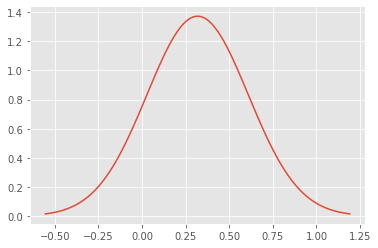

In [26]:
import numpy as np
import scipy.stats as stats

mu = mean_sim
sigma = std_sim
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

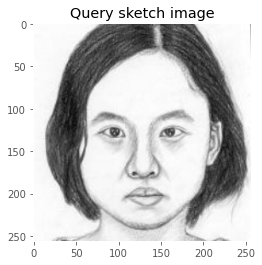

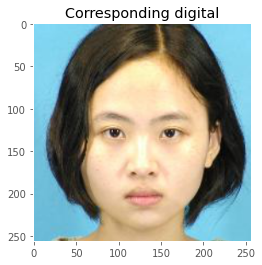

In [27]:
plt.imshow(sketch.squeeze().cpu().permute(1, 2, 0))
plt.title("Query sketch image")
plt.grid(False)
plt.show()

plt.imshow(train_photos[index].squeeze().cpu().permute(1, 2, 0))
plt.title("Corresponding digital")
plt.grid(False)
plt.show()

Matched images in descending order of similarity


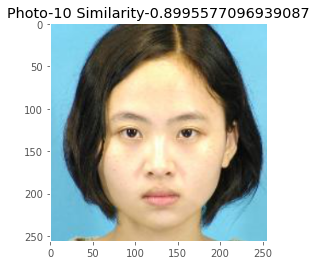

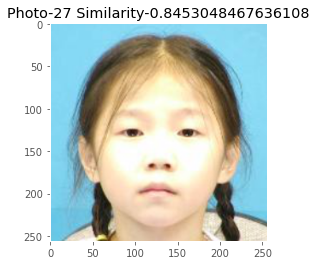

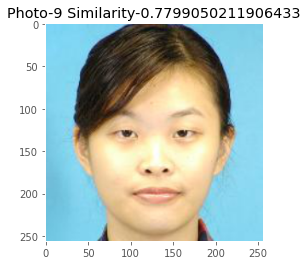

In [28]:
print("Matched images in descending order of similarity")

for idx in sorted_sim_idxs[:3]:
    plt.imshow(train_photos[idx].squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Photo-{idx} Similarity-{similarities[idx]}")
    plt.grid(False)
    plt.show()